In [39]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Flatten, Conv1D, MaxPooling1D, Activation, concatenate, BatchNormalization, Add
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler

from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
seed=42

In [2]:
df=pd.read_csv('features_flight_heli.csv')
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fname        6865 non-null   object 
 1   alt_max      6865 non-null   float64
 2   vert_acc     6865 non-null   float64
 3   horiz_speed  6865 non-null   float64
 4   dist         6865 non-null   float64
 5   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 321.9+ KB


In [3]:
df.drop(['fname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_max      6865 non-null   float64
 1   vert_acc     6865 non-null   float64
 2   horiz_speed  6865 non-null   float64
 3   dist         6865 non-null   float64
 4   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 268.3 KB


In [4]:
Y = df['is_maneuver']
X = df.drop(['is_maneuver'], axis=1)

print(X.shape)
print(Y.shape)

(6865, 4)
(6865,)


In [5]:
df['is_maneuver'].value_counts()

1    5104
0    1761
Name: is_maneuver, dtype: int64

In [6]:
class_counts = df['is_maneuver'].value_counts()

# Calculate the target number of samples for the majority class
target_count = class_counts.min()

# Use groupby and sample to reduce the majority class
df = df.groupby('is_maneuver').apply(lambda group: group.sample(target_count))

print("Balanced class distribution:")
print(df['is_maneuver'].value_counts())

Balanced class distribution:
0    1761
1    1761
Name: is_maneuver, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

In [8]:
X_train = np.array(X_train)
X_test=np.array(X_test)

In [9]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [28]:
inputs = Input(shape=(X_train.shape[1],))

# Define the architecture of your model
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu')(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model10 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model10.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [29]:
history10= model10.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[lr_reduction, early_stopping])

Epoch 1/100
138/138 [==============================] - 6s 21ms/step - loss: 1.3025 - accuracy: 0.7608 - val_loss: 1.1211 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 1s 10ms/step - loss: 1.1186 - accuracy: 0.8261 - val_loss: 1.0737 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 1s 10ms/step - loss: 1.0443 - accuracy: 0.8343 - val_loss: 1.0177 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 1s 11ms/step - loss: 1.0064 - accuracy: 0.8397 - val_loss: 0.9857 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 2s 12ms/step - loss: 0.9597 - accuracy: 0.8529 - val_loss: 0.9494 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 2s 12ms/step - loss: 0.9182 - accuracy: 0.8511 - val_loss: 0.9087 - val_accuracy: 0.8499 - lr: 0.0010
Epoch 7/100
138/138 [==============================] - 1s 

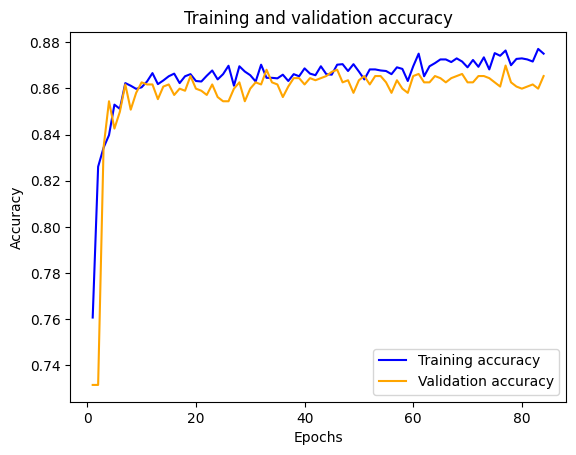

0.8770771622657776

In [30]:
acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(acc)

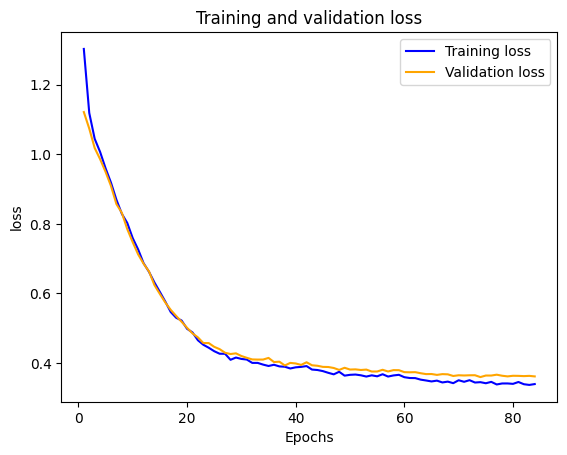

1.3025258779525757

In [31]:
loss = history10.history['loss']
val_loss = history10.history['val_loss']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


np.max(loss)

In [42]:
loss, accuracy = model10.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

43/43 [==============================] - 0s 4ms/step - loss: 0.3463 - accuracy: 0.8696
Test Loss: 0.3463
Test Accuracy: 0.8696


In [47]:
y_pred = model10.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

43/43 [==============================] - 0s 5ms/step


In [48]:
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

Test Precision: 0.8971698113207547
Test Recall: 0.931439764936337
Test F1 Score: 0.9139836617011053


In [49]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Print AUC
print("AUC:", roc_auc)

AUC: 0.9036483839373163


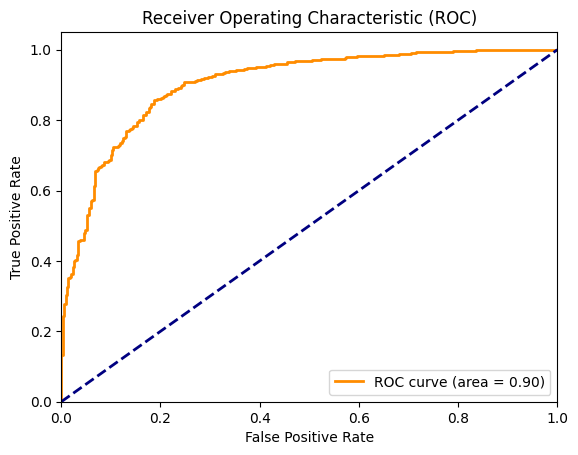

In [50]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()